In [47]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

In [48]:
from caffe import layers as L, params as P

def lenet(hdf5_list, batch_size=64):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5_list, ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.pool1 = L.Pooling(n.relu1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.pool2 = L.Pooling(n.relu2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu3 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu3, num_output=30, weight_filler=dict(type='xavier'))
    n.loss =  L.EuclideanLoss(n.score, n.label)
    
    return n.to_proto()

train_net_path = 'train_net.prototxt'
test_net_path = 'test_net.prototxt'
batch_size = 64
with open(train_net_path, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/train_hdf5.list', batch_size=batch_size)))
    
with open(test_net_path, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/test_hdf5.list', batch_size=batch_size)))

In [49]:
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path

s.test_net.append(test_net_path)
s.test_iter.append(1) # Test on 100 batches each time we test.

s.test_net.append(train_net_path)
s.test_iter.append(1) # Test on 100 batches each time we test.


s.test_interval = 1000000  # Test after every 500 training iterations.


s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "Adam"

# Set the initial learning rate for SGD.
s.base_lr = 0.0001  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 0

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 2

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 1000000
s.snapshot_prefix = 'lenet_'

s.snapshot_after_train = True

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.CPU


solver_config_fname = 'lenet_solver.prototxt'
# Write the solver to a temporary file and return its filename.
with open(solver_config_fname, 'w') as f:
    f.write(str(s))

In [50]:
import os
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']

loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']


In [51]:
%%time

import h5py
td_size = 64
f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.close()

f = h5py.File('../data/test_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_val_clean_cv, compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_val_clean_cv, compression='gzip', compression_opts=4)
f.close()



solver = None
solver = caffe.get_solver(solver_config_fname)

CPU times: user 3.81 s, sys: 47.8 ms, total: 3.86 s
Wall time: 3.96 s


In [52]:
%%time
solver.step(1)

CPU times: user 6.2 s, sys: 244 ms, total: 6.45 s
Wall time: 3.76 s


In [53]:
%%time
solver.step(1)

CPU times: user 4.8 s, sys: 47.9 ms, total: 4.85 s
Wall time: 2.88 s


In [54]:
%%time
# solver.step(10)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 10 µs


In [55]:
%%time
if 0:
    td_size = 1
    f = h5py.File('../data/train_data_lenet.hd5', 'w')
    f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
    f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
    f.close()

    solver = None
    solver = caffe.get_solver(solver_config_fname)

    num_epochs = 100
    num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
    niter = num_iter_per_epoch * num_epochs

    #val_data_size = X_val_clean_cv.shape[0]
    val_data_size = 4*batch_size

    print "td_size = %d" % td_size
    print "niter = %d" % niter

    solver.step(niter)

    train_error_check = solver.net.blobs['loss'].data

    print "testing..."

    val_error = 0
    val_error_check = 0
    niter_val = int(np.ceil( float(val_data_size) / batch_size))
    for test_it in range(niter_val):
        solver.test_nets[0].forward()
        val_error += np.sum( (solver.test_nets[0].blobs['score'].data -
                             solver.test_nets[0].blobs['label'].data) ** 2) / (2 * float(val_data_size))
        val_error_check += solver.test_nets[0].blobs['loss'].data / niter_val


    train_error = 0
    for test_it in range(num_iter_per_epoch):
        solver.test_nets[1].forward()
        train_error += np.sum( (solver.test_nets[1].blobs['score'].data -
                             solver.test_nets[1].blobs['label'].data) ** 2) / (2 * float(num_iter_per_epoch * batch_size))

    print "train_error = %f, train_error_check = %f, \
    val_error = %f, val_error_check = %f" % \
            (train_error, train_error_check, val_error, val_error_check)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 11.9 µs


In [58]:
%%time
td_size = 50
f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.close()

solver = None
solver = caffe.get_solver(solver_config_fname)

num_epochs = 10
num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
niter = num_iter_per_epoch * num_epochs

#val_data_size = X_val_clean_cv.shape[0]
val_data_size = 2*batch_size
niter_val = int(np.ceil( float(val_data_size) / batch_size))
val_interval = num_iter_per_epoch

print "td_size = %d" % td_size
print "niter = %d" % niter

train_error = np.zeros(niter)
val_error = np.zeros( int(np.ceil(float(niter) / val_interval)))

for it in range(niter):
    solver.step(1)
    
    train_error[it] = solver.net.blobs['loss'].data
    
    if (it % val_interval) == 0:
        
        val_error_this = 0
        for test_it in range(niter_val):
            solver.test_nets[0].forward()
            val_error_this += solver.test_nets[0].blobs['loss'].data / niter_val
        
        val_error[it // val_interval] = val_error_this

solver.net.save('lenet_trained.caffemodel')

td_size = 50
niter = 10
CPU times: user 1min 6s, sys: 872 ms, total: 1min 6s
Wall time: 37.9 s


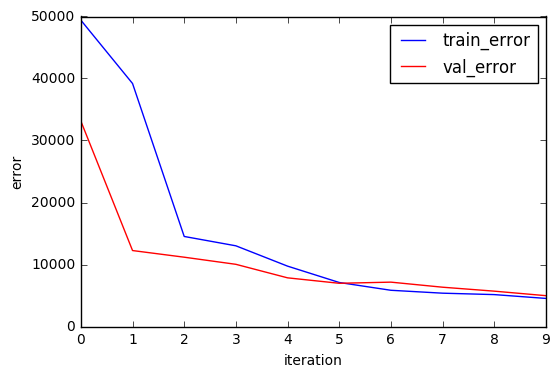

In [57]:
import matplotlib.pyplot as plt

_, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.plot(range(niter), train_error, label='train_error')
ax1.plot(val_interval * range(len(val_error)), val_error, 'r', label='val_error')
ax1.legend()
ax1.set_xlabel('iteration')
ax1.set_ylabel('error')